In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn

In [3]:
torch.cuda.is_available()

True

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
                nn.Conv2d(channels_img,features_d, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d,features_d*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*2),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*2,features_d*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*4),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*4,features_d*8, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_d*8),
                nn.LeakyReLU(0.2),
                nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=0),
                nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
                nn.ConvTranspose2d(channels_noise,features_g*16, kernel_size=4, stride=1, padding=0),
                nn.BatchNorm2d(features_g*16),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*16,features_g*8, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*8),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*8,features_g*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*4),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*4,features_g*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(features_g*2),
                nn.ReLU(),
                nn.ConvTranspose2d(features_g*2,channels_img, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
        )
        
    def forward(self, x):
        return self.gen(x)

In [6]:
#  !conda install tensorboard -y

In [7]:
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 1
channels_noise = 256
num_epochs = 10
features_d = 16
features_g = 16

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [9]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 162937213.89it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 48963497.91it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 49379472.47it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8497113.63it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [11]:
gen = Generator(channels_noise, channels_img, features_g)
gen = gen.to(device)
disc = Discriminator(channels_img, features_d)
disc = disc.to(device)


In [12]:
gen_optim = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optim = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [13]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

In [14]:
fixed_noise = torch.randn(64, channels_noise, 1,1 ).to(device)

In [15]:
writer_real = SummaryWriter(f'kaggle/output/working/GAN_MNIST/Real')
writer_fake = SummaryWriter(f'kaggle/output/working/GAN_MNIST/fake')


print("Starting training...")

for epoch in range(num_epochs):
    for batch_index, (images, targets) in enumerate(dataloader):
  #      print(device)
        images = images.to(device)
 #       print(images.dtype, images.device)
        batch_size = images.shape[0]
        ## Train Discriminator
        disc.zero_grad()
        labels = (torch.ones(batch_size)*0.9).to(device) # 1 for real images but set it to 0.9
        outputs = disc(images).reshape(-1) # classifiy real images
        loss_disc_real = criterion(outputs, labels) # loss on real images
        Disc_x = outputs.mean().item()
        
        noise = torch.randn(batch_size, channels_noise, 1,1).to(device)
        fake = gen(noise) # generate fake image from noise
        labels = (torch.ones(batch_size)*0.1).to(device) # 0 for fake images but set it to 0.1
        outputs = disc(fake.detach()).reshape(-1) # classifiy fake images, generate fake images and back prop
        loss_disc_fake = criterion(outputs, labels) # loss on fake images
        
        loss_disc = loss_disc_real + loss_disc_fake # total loss
        
        loss_disc.backward()
        disc_optim.step()
        
        
        ## Train Generator
        
        gen_optim.zero_grad()
        labels = torch.ones(batch_size).to(device)
        outputs = disc(fake).reshape(-1) # generate fake image with gradients and back prop
        loss_gen = criterion(outputs, labels)
        loss_gen.backward()
        gen_optim.step()
        
        if batch_index % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} Batch {batch_index}/{len(dataloader) } Loss Disc: {loss_disc:.4f} Loss gen: {loss_gen:.4f} Disc_X: {Disc_x:.4f}")
            
            
            with torch.no_grad():
                fake = gen(fixed_noise)
                
                img_grid_real = torchvision.utils.make_grid(images[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image("MNIST Real Images", img_grid_real)
                writer_fake.add_image("MNIST Fake Images", img_grid_fake)

Starting training...
Epoch 0/10 Batch 0/938 Loss Disc: 1.3647 Loss gen: 0.9027 Disc_X: 0.5192
Epoch 0/10 Batch 10/938 Loss Disc: 0.9666 Loss gen: 1.5663 Disc_X: 0.7475
Epoch 0/10 Batch 20/938 Loss Disc: 0.8477 Loss gen: 2.2423 Disc_X: 0.7958
Epoch 0/10 Batch 30/938 Loss Disc: 0.7389 Loss gen: 2.5910 Disc_X: 0.8617
Epoch 0/10 Batch 40/938 Loss Disc: 0.6947 Loss gen: 2.8659 Disc_X: 0.8621
Epoch 0/10 Batch 50/938 Loss Disc: 0.6915 Loss gen: 2.7800 Disc_X: 0.8572
Epoch 0/10 Batch 60/938 Loss Disc: 0.6779 Loss gen: 2.9836 Disc_X: 0.8805
Epoch 0/10 Batch 70/938 Loss Disc: 0.6673 Loss gen: 2.8950 Disc_X: 0.8926
Epoch 0/10 Batch 80/938 Loss Disc: 0.6689 Loss gen: 2.8670 Disc_X: 0.8856
Epoch 0/10 Batch 90/938 Loss Disc: 0.6590 Loss gen: 2.8447 Disc_X: 0.8929
Epoch 0/10 Batch 100/938 Loss Disc: 0.6688 Loss gen: 3.3470 Disc_X: 0.8975
Epoch 0/10 Batch 110/938 Loss Disc: 0.6606 Loss gen: 2.7802 Disc_X: 0.8849
Epoch 0/10 Batch 120/938 Loss Disc: 0.6644 Loss gen: 2.6845 Disc_X: 0.8732
Epoch 0/10 Batc

In [16]:
images, labels = next(iter(dataloader))
test_noise = torch.randn(1, channels_noise, 1,1 ).to(device)
outputs = gen(test_noise).squeeze()

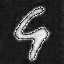

In [17]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
])
image = transform_test(outputs)
image

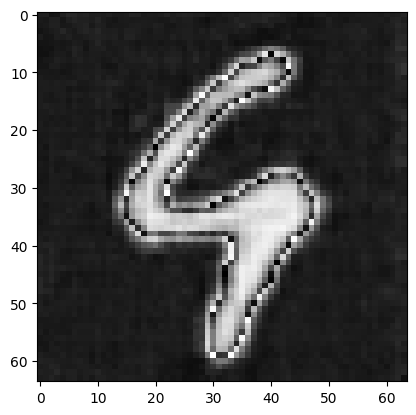

In [18]:

plt.imshow(image, cmap='gray')